**Import data:**

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import matplotlib.pyplot as plt
import pandas as pd


In [0]:
%cd /gdrive/My\ Drive/CAE\ Challenge

/gdrive/My Drive/CAE Challenge


In [0]:
df=pd.read_csv("CAE_dataset.csv")

In [0]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,label,Id
0,0,0.134880,-42.08892,-0.037386,-0.184788,50.546875,19.775391,86.24073,-0.304381,-0.452958,132.4768,0,327
1,1,0.134641,-41.84206,-0.036891,-0.181393,50.468750,19.775391,86.99523,-0.290598,-0.421575,132.4768,0,327
2,2,0.135263,-41.84206,-0.035995,-0.181039,50.000000,19.726562,86.99523,-0.273311,-0.383049,132.4768,0,327
3,3,0.136999,-41.58644,-0.035182,-0.182234,50.000000,18.359375,87.54987,-0.254571,-0.338215,132.4768,0,327
4,4,0.139939,-41.58644,-0.034691,-0.183275,50.000000,15.673828,87.85726,-0.236445,-0.287707,132.4768,0,327


In [0]:
df[df.isnull().any(1)].head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,label,Id
2598,2598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,234
2793,2793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,234
5468,5468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,217
5789,5789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,217
5969,5969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,217


In [0]:
df.interpolate()[df.isnull().any(1)].head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,label,Id
2598,2598,12.986769,-298.26320,1.406424,8.025964,62.910156,56.616211,93.681240,-3.629676,-3.244712,132.8226,0,234
2793,2793,-94.987747,-125.07275,-1.131984,12.806697,50.000000,48.413086,93.803695,0.208563,-0.845462,132.8042,0,234
5468,5468,0.765672,-39.98327,-0.052114,-0.009748,50.000000,37.841797,84.434830,-0.249234,-0.034420,132.4972,0,217
5789,5789,10.602059,-232.66715,0.030933,-0.239854,42.187500,60.327148,82.120195,-0.426745,-1.639856,132.4360,0,217
5969,5969,-66.237178,-203.70510,-1.709171,12.894523,37.890625,45.214844,93.719870,-1.577958,-3.704270,132.4259,0,217


In [0]:
df = df.interpolate()

In [0]:
df.shape

(385768, 13)

In [0]:
df["Id"].unique().shape

(444,)

In [0]:
from collections import Counter

idx_to_label = df[["Id","label"]].drop_duplicates()
Counter(idx_to_label["label"])

Counter({0: 291, 1: 153})

**Construct learning matrix**

In [0]:
import numpy as np
def seperate_ts(data, ids):
    ts = []
    for idx in ids:
        features = []
        for feature in range(10):
            features.append(df.loc[df["Id"]==idx,f"{feature}"].values)
        ts.append(np.array(features))
    return ts
all_ts = seperate_ts(df, idx_to_label["Id"].values)
len(all_ts)

444

In [0]:
def pre_process(data, labels, window = 300, step = 30):
    new_data = []
    new_labels = []
    for timeserie, label in tqdm.tqdm_notebook(zip(data,labels)):
        for offset in np.arange(0,timeserie.shape[1],step):
            if offset+window>=timeserie.shape[1]:break
            new_data.append(timeserie[:,offset:offset+window])
            new_labels.append(label)

    return np.array(new_data), np.array(new_labels)


In [0]:
import tqdm
from sklearn.model_selection import train_test_split

def get_train_test_data(data, labels, test_size=0.1, window = 300, step = 100):
    Xtr_idx, Xts_idx = train_test_split(range(len(labels)), test_size=test_size, stratify = labels, random_state=6)
    Xtr_in = [data[k] for k in Xtr_idx]
    Xts_in = [data[k] for k in Xts_idx]
    Ytr_in = [labels[k] for k in Xtr_idx]
    Yts_in = [labels[k] for k in Xts_idx]

    #print(Xtr_in)
    Xtr,Ytr = pre_process(Xtr_in, Ytr_in, window = window, step = step)
    Xts,Yts = pre_process(Xts_in, Yts_in, window = window, step = step)
    
    return Xtr.transpose((0,2,1)), Ytr, Xts.transpose((0,2,1)), Yts

Xtr, Ytr, Xts, Yts = get_train_test_data(all_ts, idx_to_label["label"].values, window = 500, step = 50)
Xtr.shape

(3132, 500, 10)

**Models**

In [0]:
import keras
#Build the model

model_cnn = keras.Sequential([
    #conv_pool_block_1
    keras.layers.Conv2D(filters=25, kernel_size=(10,1), dilation_rate=(1, 1),strides=(1, 1), padding='valid', 
                        activation='relu', input_shape=(Xtr.shape[1],Xtr.shape[2],1)),
    #keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=25, kernel_size=(1, Xtr.shape[2]),strides=(1, 1), padding='valid', 
                        activation='relu'),
    #keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),    
    keras.layers.MaxPool2D(pool_size=(3,1)),

    #conv_pool_block_2
    keras.layers.Conv2D(filters=50, kernel_size=(10,1),strides=(1, 1), padding='valid', activation='relu'),
    #keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,1)),
    
    #conv_pool_block_3
    keras.layers.Conv2D(filters=100, kernel_size=(10,1),strides=(1, 1), padding='valid', activation='relu'),
    #keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,1)),
    
    #conv_pool_block_3
    keras.layers.Conv2D(filters=200, kernel_size=(3,1),strides=(1, 1), padding='valid', activation='relu'),
    #keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,1)),
    

    #classification Layer
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(0.5),
    # keras.layers.Dense(100),
    #keras.layers.Dropout(0.3),
    # keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
    ])

model_lstm = keras.Sequential([
    keras.layers.LSTM(100, input_shape=(Xtr.shape[1],Xtr.shape[2])),
    keras.layers.Dense(1, activation='sigmoid'),
])
# Take a look at the model summary
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 44,501
Trainable params: 44,501
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_lstm.load_weights("weights_model.hd5")

**Train:**

In [0]:
model.compile(optimizer=keras.optimizers.Adam(lr=5e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(Xtr, 
          Ytr, 
          batch_size=32, 
          epochs=100,
          validation_data =[Xts, Yts],shuffle=True)

In [0]:
Xts.shape

(359, 500, 10)

In [0]:

predictions = model_lstm.predict(Xts)

In [0]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(Yts, predictions.ravel()>0.5))
print(classification_report(Yts, predictions.ravel()>0.5))

[[155  40]
 [ 52 112]]
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       195
           1       0.74      0.68      0.71       164

    accuracy                           0.74       359
   macro avg       0.74      0.74      0.74       359
weighted avg       0.74      0.74      0.74       359



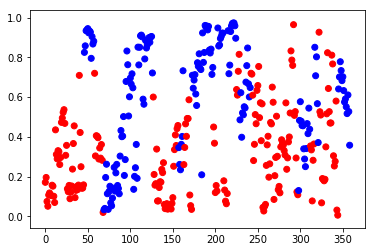

In [0]:
plt.scatter(range(len(predictions)),predictions.ravel(),c=np.where(Yts==0,"red","blue"))

In [0]:
model.save_weights("weights_model.hd5")